In [13]:
from pathlib import Path
from array import array
import struct
import cv2 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from one_layer_nn import OneLayerNN
import torch
import torch.nn as nn

### Read data

In [5]:
def read_image_data(path):
    data_dir = Path("./data")
    with open(data_dir / path, "rb") as f:
        # IDX file format
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        image_data = array("B", f.read())   
    images = []
    for i in range(size):
        image = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(28, 28)
        images.append(image)
    return np.array(images)


def read_labels(path):
    data_dir = Path("./data")
    with open(data_dir / path, "rb") as f:
        magic, size = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = np.array(array("B", f.read()))
    return labels

In [6]:
train_val_labels = read_labels("train-labels.idx1-ubyte")
train_val_images = read_image_data("train-images.idx3-ubyte")
test_images = read_image_data("t10k-images.idx3-ubyte")
test_labels = read_labels("t10k-labels.idx1-ubyte")
print(train_val_images.shape)

(60000, 28, 28)


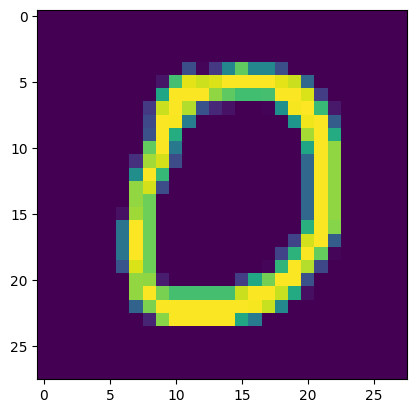

In [7]:
# Show image

plt.imshow(test_images[10])


### Process

In [8]:
def onehot(label):
    encoded_label = np.zeros(10)
    encoded_label[label] = 1
    return encoded_label

In [9]:
# Set trainning dataset
# Set validate dataset

train_images = train_val_images[:int(0.9 * len(train_val_images))]
val_images = train_val_images[len(train_images):]

train_labels = train_val_labels[:len(train_images)]
val_labels = train_val_labels[len(train_images):]


In [10]:
one_layer_nn = OneLayerNN()

In [14]:
torch_train_images = torch.Tensor(train_images).reshape(-1, 28 * 28)
torch_val_images = torch.Tensor(val_images).reshape(-1, 28 * 28)
torch_test_images = torch.Tensor(test_images).reshape(-1, 28 * 28)
torch_train_labels = torch.Tensor([onehot(label) for label in train_labels])
torch_val_labels = torch.Tensor([onehot(label) for label in val_labels])
torch_test_labels = torch.Tensor([onehot(label) for label in test_labels])
torch_train_dataset = torch.hstack((torch_train_labels, torch_train_images))


/tmp/ipykernel_25189/4021182234.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  torch_train_labels = torch.Tensor([onehot(label) for label in train_labels])


In [15]:
optim = torch.optim.SGD(params=one_layer_nn.parameters(), lr=1e-3)

In [16]:
one_layer_nn = OneLayerNN()
optim = torch.optim.SGD(params=one_layer_nn.parameters(), lr=1e-3)
train_losses = []
val_losses = []
epochs = 30
batch_size = 10
val_predictions = []
for epoch in range(epochs):
    shuffled_order = torch.randperm(len(torch_train_dataset))
    val_predictions = []
    for index in range(len(shuffled_order) // batch_size):
        batch = torch_train_dataset[shuffled_order[index * batch_size:(index + 1) * batch_size]]
        y_true = batch[:,:10]
        y_pred = one_layer_nn(batch[:,10:]) # What's happen?
        loss = torch.nn.functional.cross_entropy(y_pred, y_true) # What's happen?
        optim.zero_grad() # Chuyen grad ve 0
        loss.backward() # Backward 
        optim.step()
        train_losses.append(loss.detach())
    with torch.no_grad():
        for batch in range(len(torch_val_images) // batch_size):
            y_pred = one_layer_nn(torch_val_images[batch * batch_size:(batch + 1) * batch_size])
            y_true = torch_val_labels[batch * batch_size:(batch + 1) * batch_size]
            loss = torch.nn.functional.cross_entropy(y_pred, y_true)
            val_losses.append(loss)
            val_predictions.extend(torch.argmax(y_pred, axis=1))
        print("Val Loss", (sum(val_losses) / len(val_losses)).item())
        print("Accuracy", sum(np.array(val_predictions) == val_labels) / len(val_labels))

Val Loss 0.20985274016857147
Accuracy 0.9393333333333334
Val Loss 0.21142853796482086
Accuracy 0.944
Val Loss 0.19662968814373016
Accuracy 0.9566666666666667
Val Loss 0.18643616139888763
Accuracy 0.9593333333333334
Val Loss 0.1822238713502884
Accuracy 0.9603333333333334
Val Loss 0.18014958500862122
Accuracy 0.9583333333333334
Val Loss 0.17943190038204193
Accuracy 0.9613333333333334
Val Loss 0.17741777002811432
Accuracy 0.9633333333333334
Val Loss 0.17686671018600464
Accuracy 0.9618333333333333
Val Loss 0.17609421908855438
Accuracy 0.9658333333333333
Val Loss 0.17542989552021027
Accuracy 0.9663333333333334
Val Loss 0.17829130589962006
Accuracy 0.9618333333333333
Val Loss 0.17949818074703217
Accuracy 0.9628333333333333
Val Loss 0.18042023479938507
Accuracy 0.9681666666666666
Val Loss 0.18189674615859985
Accuracy 0.9655
Val Loss 0.1840190589427948
Accuracy 0.9636666666666667
Val Loss 0.18626224994659424
Accuracy 0.9661666666666666
Val Loss 0.1872359961271286
Accuracy 0.9693333333333334
Va

In [17]:
torch.save(one_layer_nn.state_dict(), 'model_weights.pth')

In [23]:
model = OneLayerNN()
model.load_state_dict(torch.load('model_weights.pth'))
def convert_img_to_mnist(path):
    image = Image.open(path)

    # Convert the image to grayscale
    image = image.convert('L')

    # Resize the image to 28x28 pixels
    image = image.resize((28, 28))

    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Ensure pixel values are within the range [0, 255]
    image_array = (image_array / 255.0) * 255
    image_array = torch.Tensor(image_array).reshape(-1, 28 * 28)
    test_predictions = []
    with torch.no_grad():
        y_pred = one_layer_nn(image_array[:])
        test_predictions.extend(torch.argmax(y_pred, axis=1))
        print(test_predictions)
    test_predictions = torch.Tensor(test_predictions).numpy().astype(np.uint8)
    print(test_predictions)

In [33]:
model = OneLayerNN()
model.load_state_dict(torch.load('model_weights.pth'))
def convert_img_to_mnist_2(path):
    image = Image.open(path)

    # Convert the image to grayscale
    image = image.convert('L')

    # Resize the image to 28x28 pixels
    image = image.resize((28, 28))

    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Ensure pixel values are within the range [0, 255]
    image_array = (image_array / 255.0) * 255
    image_array = torch.Tensor(image_array).reshape(-1, 28 * 28)
    test_predictions = []
    y_pred = one_layer_nn(image_array[:])
    max_index = np.argmax(y_pred.detach().numpy())
    print(max_index)

In [34]:
image_array = convert_img_to_mnist_2('out.png')

8
